In [1]:
# when you change a setting you have to restart the kernel (settings are only loaded once)
import os
import sys
sys.path.append('..')
from src.kitti import *
%matplotlib inline
import numpy as np
import glob

In [2]:
%%time
set_sequence(7)
set_stereo_confidence(1.6)
set_sequence_confidence(1.6)
set_patch_size(17)

frame = []
for filename in sorted(glob.glob(get_leftdir() + '/*')):
    left_frame = Frame(filename)
    frame.append(left_frame)

CPU times: user 2.42 ms, sys: 4.64 ms, total: 7.06 ms
Wall time: 6.22 ms


for o in sorted(frame[195].get_observations(), key=lambda x: x.cx):
    print(o.cx, o.cy)

In [3]:
seq = Sequence()
for f in ProgressBar()(frame[200:209]):
    seq.add_keyframe(f, run_ba=False)

 11% (1 of 9) |###                        | Elapsed Time: 0:00:00 ETA:  0:00:04

connected mappoints  0


 22% (2 of 9) |######                     | Elapsed Time: 0:00:01 ETA:  0:00:05

connected mappoints  85


 33% (3 of 9) |#########                  | Elapsed Time: 0:00:02 ETA:  0:00:04

connected mappoints  79


 44% (4 of 9) |############               | Elapsed Time: 0:00:03 ETA:  0:00:04

connected mappoints  89


 55% (5 of 9) |###############            | Elapsed Time: 0:00:04 ETA:  0:00:03

connected mappoints  95


 66% (6 of 9) |##################         | Elapsed Time: 0:00:04 ETA:  0:00:02

connected mappoints  60


 77% (7 of 9) |#####################      | Elapsed Time: 0:00:05 ETA:  0:00:01

connected mappoints  17


 88% (8 of 9) |########################   | Elapsed Time: 0:00:06 ETA:  0:00:00

connected mappoints  46


100% (9 of 9) |###########################| Elapsed Time: 0:00:07 Time: 0:00:07


connected mappoints  87


In [4]:
poses = np.array([ f.get_pose().flatten() for f in seq.keyframes ])
poses[:,[3,11]]

array([[ 0.        ,  0.        ],
       [-0.01680608, -1.17478551],
       [-0.1160288 , -1.33165927],
       [ 0.04845595, -1.05726623],
       [-0.15494794, -1.28731976],
       [-0.49790945, -1.8969126 ],
       [-0.73620172, -1.71685198],
       [-0.02364836, -2.66706795],
       [ 0.03480559, -2.76718038]])

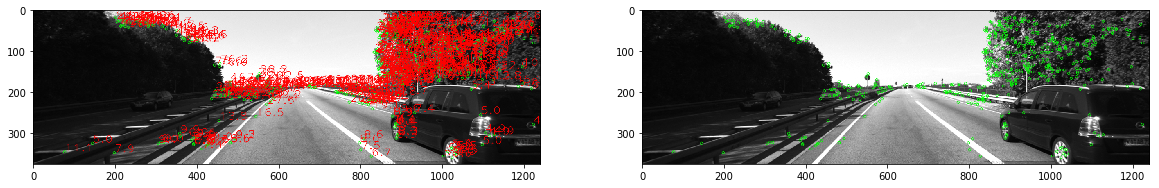

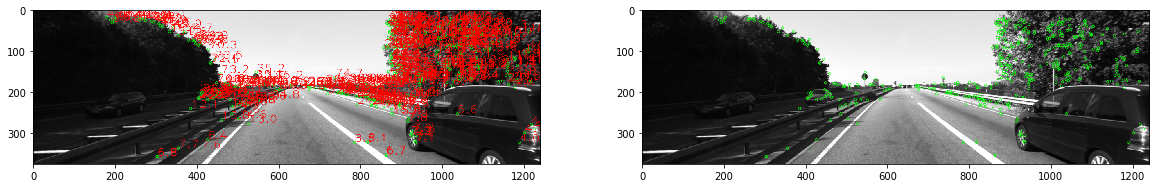

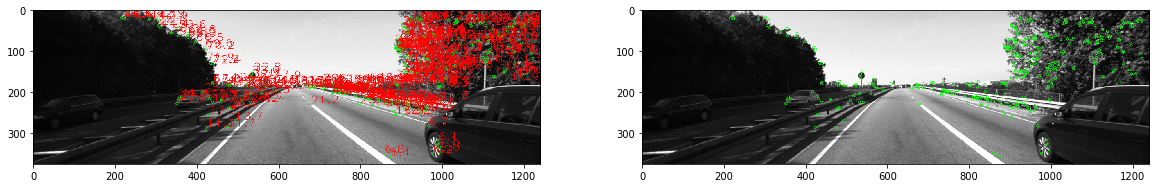

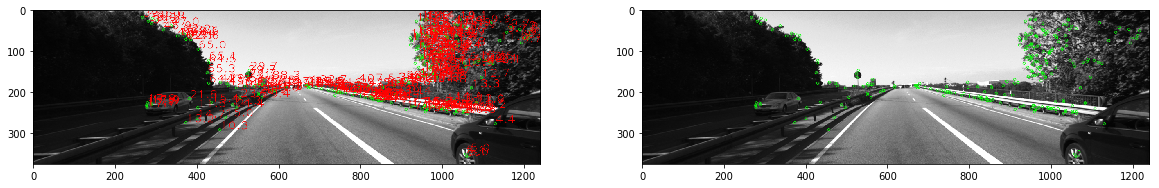

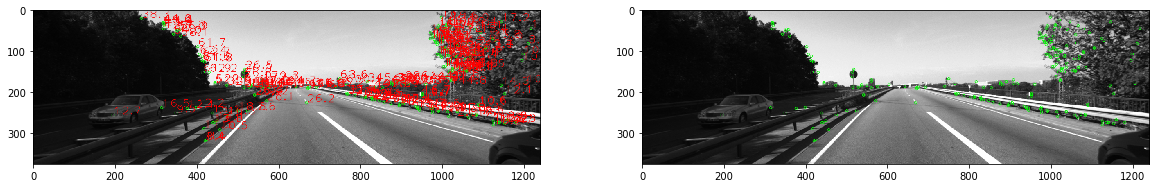

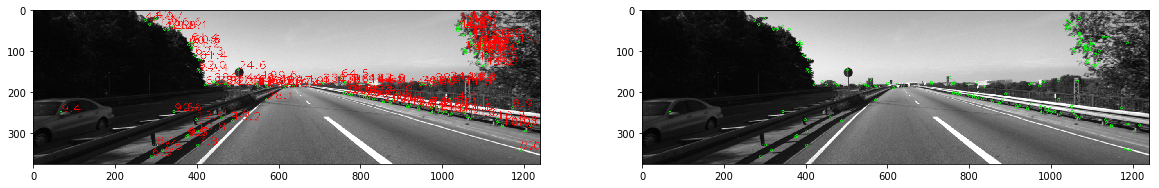

In [5]:
for i in range(203, 209):
    obs = frame[i].get_static_observations()
    #if i > 195:
    #    obs = [o for o in obs if frame[i-1] in [p.frame for p in o.mappoint.observations]]
    show2(draw_frame_depth(frame[i]), draw_observations(obs))

In [6]:
def pose_frame2(frame, keyframe, sequence_confidence = 1.6):
    keyframeobservations = keyframe.get_static_observations()
    matches = match_frame(frame, keyframeobservations, sequence_confidence = sequence_confidence)
    previous_frame = keyframe.frames[-1] if len(keyframe.frames) > 0 else keyframe
    diff = sys.maxsize
    obssets = []
    poses = []
    while len(matches) > 1:
        pose, points_left = get_pose(matches)
        frame.set_pose(pose)
        bestmatches, matches = responsible_observations(matches)
        obssets.append(bestmatches)
        poses.append(pose)
        diffn = diff2(pose, previous_frame.get_pose())
        print(diffn)
        print(pose)
        if len(bestmatches) == 0:
            break
        #if diffn < diff:
        #    diff = diffn
        #    bestpose = pose
            #if previous_frame == keyframe and keyframe.get_previous_keyframe() is None:
            #    break
        #else:
        #    break
    obssets.append(matches)
            
    return obssets, poses

In [7]:
def test(id):
    keyframe = frame[id]
    keyframe.clean()
    keyframe.frames = []
    #keyframe.set_pose( np.eye(4) )
    keyframe.compute_depth()
    keyframe.filter_has_depth()
    for obs in keyframe.get_observations():
        if not obs.has_mappoint() and obs.get_depth() is not None:
            obs.create_mappoint(0)
    newframe = frame[id+1]
    newframe.clean()
    return pose_frame2(newframe, keyframe)

In [8]:
test(207);

0.0137935589858
[[  9.99990196e-01  -2.07766567e-03  -3.91028713e-03   3.48055943e-02]
 [  2.06521806e-03   9.99992796e-01  -3.18464794e-03   6.03556318e-02]
 [  3.91687560e-03   3.17654112e-03   9.99987284e-01  -2.76718038e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [9]:
m, poses = test(207)
obssets = [[o for o, _ in m[i]] for i in range(len(m))]

0.0137935589858
[[  9.99990196e-01  -2.07766567e-03  -3.91028713e-03   3.48055943e-02]
 [  2.06521806e-03   9.99992796e-01  -3.18464794e-03   6.03556318e-02]
 [  3.91687560e-03   3.17654112e-03   9.99987284e-01  -2.76718038e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [10]:
len(obssets[1])

1

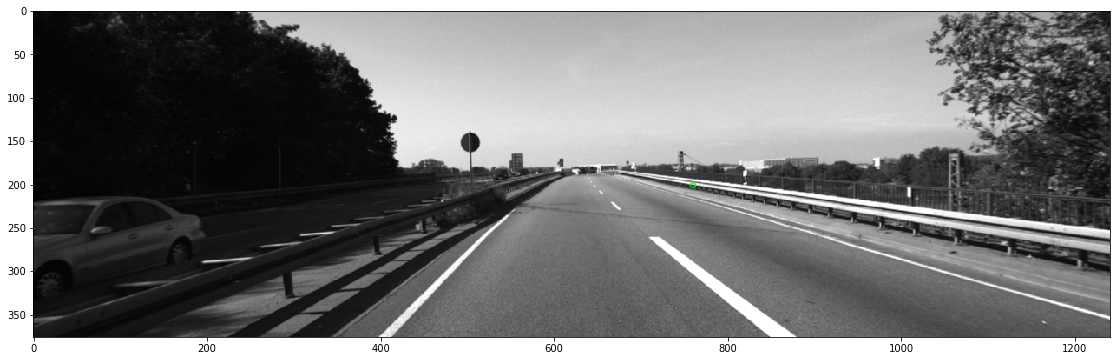

In [11]:
show(draw_observations(obssets[1]))

In [12]:
for o in sorted(obssets[1], key=lambda x: x.cx):
    print(o.reproject())

(760, 201, 18.286512335408361, 2.9425045308945244)


In [13]:
for o,p in sorted(m[1], key=lambda x: x[0].cx):
    print(o.cx, o.cy, p.cx, p.cy)

760 201 766 203


In [14]:
len(obssets)

2

In [15]:
o = 3
print(len(obssets[o]))
if o < len(poses):
    print(poses[o])
show(draw_observations(obssets[o]))

IndexError: list index out of range

In [ ]:
for f in range(205,207):
    frame[f].clean()
    frame[f].compute_depth()
    frame[f].filter_has_depth()


In [ ]:
matches = match_frame(frame[206], frame[205].get_observations())
dist = [ ((f.get_affine_coords()[2] - k.get_affine_coords()[2]), f, k) for f, k in matches ]
for o,p in matches:
    p.create_mappoint(0)
    o.set_mappoint_no_check(p.get_mappoint())
sorted(dist)

In [ ]:
f4 = [ f for _, f, _ in sorted(dist)[:]]
k4 = [ k for _, _, k in sorted(dist)[:]]
show(draw_observations_depth(f4))
show(draw_observations_depth(k4))



In [ ]:
odist = [ m for m in matches if m[0].get_depth() > 0]
pose, pointsleft = get_pose(odist)
#pose = np.eye(4)
#pose[2,3] = -1.0
frame[206].set_pose(pose)
pose

In [ ]:
r = [ o.reproject() for o,k in matches ]
sorted([ (o[0], o[1], o[2]) for o in r ], key=lambda x: x[0])

#sum([abs(x[2]) for x in r])
#o289 = [ o for o,p in matches if o.cx==289][0]
#o289.get_mappoint().get_last_observation()

In [ ]:
matches = match_frame(frame[206], frame[205].get_observations())
pose, pointsleft = get_pose(matches)
frame[206].set_pose(pose)
while True:
    r = [ (o.reproject(), o, k) for o,k in matches ]
    rr = [ x[2] for x,o,k in r ]
    ravg = np.sum(rr) / len(rr)
    rstd = np.std(rr)
    print(ravg, rstd)
    l = len(matches)
    matches = [ (o,k) for x,o,k in r if x[2] > ravg - 3* rstd and x[2] < ravg + 3 * rstd ]
    pose, pointsleft = get_pose(matches)
    frame[206].set_pose(pose)
    if l == len(matches) or len(matches) == 0:
        break
matches

In [ ]:
frame[206].get_pose()

In [ ]:
show(draw_observations([ o for o, p in matches ]))

In [ ]:
get_pose(matches)

In [18]:
seq = Sequence()
seq.add_keyframe(frame[1], run_ba=False)
seq.add_keyframe(frame[1060], run_ba=False)



connected mappoints  0
2174 
 [[ 0.99979361 -0.00571642  0.01949513  0.26231702]
 [ 0.0056212   0.99997202  0.00493577 -0.00252165]
 [-0.0195228  -0.00482516  0.99979777  0.14762148]
 [ 0.          0.          0.          1.        ]]
connected mappoints  62


In [22]:
obs = [ o for o in frame[1060].get_observations() if o.has_mappoint() and len(o.mappoint.observations) == 2 ]
obs

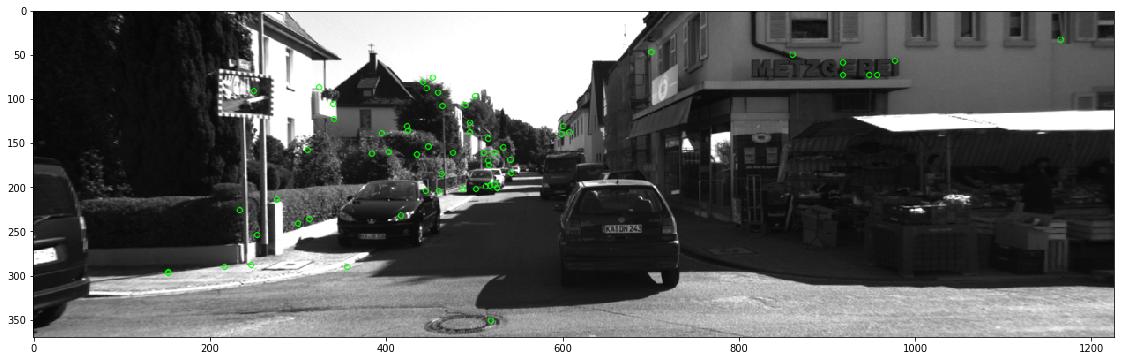

In [23]:
show(draw_observations(obs))